In [143]:
import pandas as pd
import numpy as np
import re
import lightgbm as lgb
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import compress
from sklearn import preprocessing
from sklearn.preprocessing import normalize
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import xgboost as xgb
%matplotlib inline 
train_tr = pd.read_csv("/Users/inder/Downloads/ieee-fraud-detection/train_transaction.csv") 
train_id = pd.read_csv("/Users/inder/Downloads/ieee-fraud-detection/train_identity.csv") 
test_tr = pd.read_csv("/Users/inder/Downloads/ieee-fraud-detection/test_transaction.csv") 
test_id = pd.read_csv("/Users/inder/Downloads/ieee-fraud-detection/test_identity.csv") 
submission = pd.read_csv("/Users/inder/Downloads/ieee-fraud-detection/sample_submission.csv")

In [144]:
cols = ["TransactionID"]
for i in range(1,39):
    cols.append("id"+str(i))
cols.append("DeviceType")
cols.append("DeviceInfo")
train_id.rename( columns = dict( zip( train_id.columns , cols ) ) , inplace=True)
test_id.rename( columns = dict( zip( test_id.columns , cols ) ) , inplace=True)

In [145]:
train = pd.merge(train_tr, train_id, on='TransactionID', how='left')
test = pd.merge(test_tr, test_id, on='TransactionID', how='left')
del train_tr , test_tr , train_id , test_id

In [146]:
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Train dataset has 590540 rows and 434 columns.
Test dataset has 506691 rows and 433 columns.


In [147]:
train.isFraud.value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

binary Classification.<br>isFraud == 1 count is seriously low.

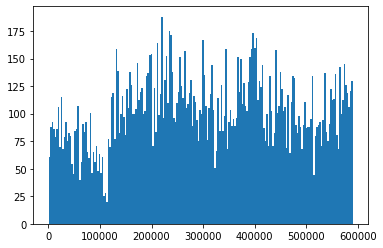

In [148]:
#plt.hist( list( compress( range(len(train_tr)) , (train_tr.isFraud==0).values ) ) ,bins=100)
plt.hist( list( compress( range(len(train)) , (train.isFraud==1).values ) ) ,bins=200)
plt.show()

In [149]:
y = train.isFraud.values
train['data'] = "train"
train

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id32,id33,id34,id35,id36,id37,id38,DeviceType,DeviceInfo,data
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train


In [150]:
test['data'] = "test"
test

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id32,id33,id34,id35,id36,id37,id38,DeviceType,DeviceInfo,data
0,3663549,18403224,31.950,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
1,3663550,18403263,49.000,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
2,3663551,18403310,171.000,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
3,3663552,18403310,284.950,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
4,3663553,18403317,67.950,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,4170235,34214279,94.679,C,13832,375.0,185.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
506687,4170236,34214287,12.173,C,3154,408.0,185.0,mastercard,224.0,debit,...,NaN,NaN,NaN,F,F,T,F,mobile,ALE-L23 Build/HuaweiALE-L23,test
506688,4170237,34214326,49.000,W,16661,490.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
506689,4170238,34214337,202.000,W,16621,516.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test


In [151]:
full = pd.concat([train.drop(["TransactionID","isFraud"],axis=1), test.drop(["TransactionID"],axis=1)], axis=0)
col_Mean_En = ["ProductCD","card4","card6","P_emaildomain"]
train_Mean_En = train[col_Mean_En]
train_Mean_En['isFraud'] = train["isFraud"]
del test , train
full

/Users/inder/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id32,id33,id34,id35,id36,id37,id38,DeviceType,DeviceInfo,data
0,86400,68.500,W,13926,NaN,150.0,discover,142.0,credit,315.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
1,86401,29.000,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
2,86469,59.000,W,4663,490.0,150.0,visa,166.0,debit,330.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
3,86499,50.000,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
4,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,...,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,34214279,94.679,C,13832,375.0,185.0,mastercard,224.0,debit,284.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
506687,34214287,12.173,C,3154,408.0,185.0,mastercard,224.0,debit,NaN,...,NaN,NaN,NaN,F,F,T,F,mobile,ALE-L23 Build/HuaweiALE-L23,test
506688,34214326,49.000,W,16661,490.0,150.0,visa,226.0,debit,327.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
506689,34214337,202.000,W,16621,516.0,150.0,mastercard,224.0,debit,177.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test


In [152]:
columns = full.columns
for col in columns:
    print(col)

TransactionDT
TransactionAmt
ProductCD
card1
card2
card3
card4
card5
card6
addr1
addr2
dist1
dist2
P_emaildomain
R_emaildomain
C1
C2
C3
C4
C5
C6
C7
C8
C9
C10
C11
C12
C13
C14
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
M1
M2
M3
M4
M5
M6
M7
M8
M9
V1
V2
V3
V4
V5
V6
V7
V8
V9
V10
V11
V12
V13
V14
V15
V16
V17
V18
V19
V20
V21
V22
V23
V24
V25
V26
V27
V28
V29
V30
V31
V32
V33
V34
V35
V36
V37
V38
V39
V40
V41
V42
V43
V44
V45
V46
V47
V48
V49
V50
V51
V52
V53
V54
V55
V56
V57
V58
V59
V60
V61
V62
V63
V64
V65
V66
V67
V68
V69
V70
V71
V72
V73
V74
V75
V76
V77
V78
V79
V80
V81
V82
V83
V84
V85
V86
V87
V88
V89
V90
V91
V92
V93
V94
V95
V96
V97
V98
V99
V100
V101
V102
V103
V104
V105
V106
V107
V108
V109
V110
V111
V112
V113
V114
V115
V116
V117
V118
V119
V120
V121
V122
V123
V124
V125
V126
V127
V128
V129
V130
V131
V132
V133
V134
V135
V136
V137
V138
V139
V140
V141
V142
V143
V144
V145
V146
V147
V148
V149
V150
V151
V152
V153
V154
V155
V156
V157
V158
V159
V160
V161
V162
V163
V164
V165
V166
V167
V168
V169
V170
V171
V

## Feature Engineering

In [153]:
d = "V"
vcols = []
for i in range(1,340):
    col = d + str(i)
    vcols.append(col)
    
d = "D"
dcols = []
for i in range(1,16):
    col = d + str(i)
    dcols.append(col)

d = "C"
ccols = []
for i in range(1,15):
    col = d + str(i)
    ccols.append(col)
    
d = "M"
mcols = []
for i in range(1,10):
    col = d + str(i)
    mcols.append(col)
    
d = "card"
cardcols = []
for i in range(1,7):
    col = d + str(i)
    cardcols.append(col)

d = "id"
idcols = []
for i in range(1,39):
    col = d + str(i)
    idcols.append(col)

### V1 to V339

In [154]:
vnull = 100*(full[vcols].isnull().sum().sort_values(ascending=False)/1097231)

In [155]:
#top 159 col in vnull.index contains large nan values
full.drop(vnull[:159].index,axis=1,inplace=True)

In [156]:
#col no. 160 to 170 in vnull.index contains about 40% nan values. 
#adding new feature isnull of above mentioned columns
for col in vnull[159:170].index:
    full[col+'_isnull'] = full[col].isnull().astype(int)
    print(col,"\n",full[col].value_counts(),"\n\n")    

V8 
 1.0     626902
2.0      13282
3.0        961
4.0        153
6.0         46
5.0         38
0.0         27
8.0          9
10.0         3
7.0          3
11.0         1
9.0          1
Name: V8, dtype: int64 


V9 
 1.0     617972
2.0      21403
3.0       1613
4.0        298
5.0         44
7.0         37
0.0         27
6.0         18
8.0          9
10.0         3
11.0         1
9.0          1
Name: V9, dtype: int64 


V4 
 1.0     511848
0.0     114136
2.0      14236
3.0        976
4.0        155
5.0         54
8.0          9
6.0          8
9.0          3
10.0         1
Name: V4, dtype: int64 


V10 
 0.0    353655
1.0    280858
2.0      6463
3.0       426
4.0        23
5.0         1
Name: V10, dtype: int64 


V7 
 1.0     599700
2.0      36365
3.0       4066
4.0        950
5.0        219
6.0         44
7.0         42
0.0         20
8.0         14
11.0         2
13.0         1
12.0         1
10.0         1
9.0          1
Name: V7, dtype: int64 


V6 
 1.0     615433
2.0      23346
3.0 

In [157]:
#Filling missing values
for col in list(set(vnull[159:170].index)-{"V10","V11"}):
    full[col].fillna(1,inplace=True)
full["V10"].fillna(0,inplace=True)
full["V11"].fillna(0,inplace=True)

In [158]:
#filling missing values in remaining columns
for col in vnull[170:].index:
    full[col].fillna(full[col].median(),inplace=True)

### id1 to id38 and DeviceType , DeviceInfo

In [159]:
idnull = 100*(full[idcols].isnull().sum().sort_values(ascending=False)/1097231)

In [160]:
idnull

id24    99.135369
id25    99.073030
id26    99.069476
id8     99.069111
id7     99.069111
id21    99.068747
id27    99.067562
id22    99.067562
id23    99.067562
id18    91.251797
id3     87.896350
id4     87.896350
id33    86.879700
id30    86.491085
id32    86.488078
id9     86.396301
id10    86.396301
id34    86.331046
id14    86.201538
id16    76.751751
id13    76.522173
id6     75.245413
id5     75.245413
id20    74.946570
id19    74.916494
id17    74.906378
id31    74.763108
id28    74.685732
id11    74.685732
id29    74.685732
id2     74.677347
id38    74.666957
id15    74.666957
id37    74.666957
id35    74.666957
id36    74.666957
id12    73.921626
id1     73.921626
dtype: float64

In [161]:
100*(full[['DeviceType','DeviceInfo']].isnull().sum().sort_values(ascending=False)/1097231)

DeviceInfo    78.698834
DeviceType    74.687099
dtype: float64

In [162]:
full.drop(idcols,axis=1,inplace=True)
full.drop(['DeviceType','DeviceInfo'],axis=1,inplace=True)

### D1 to D15

In [163]:
dnull = 100*(full[dcols].isnull().sum().sort_values(ascending=False)/1097231)

In [164]:
dnull

D7     90.972730
D12    87.790082
D9     86.396301
D8     86.396301
D14    83.833760
D13    83.108753
D6     81.957309
D5     48.687651
D2     46.987918
D3     42.472369
D11    41.541389
D4     22.399385
D15     9.221577
D10     8.071865
D1      0.665311
dtype: float64

In [165]:
#top 7 col in dnull.index contains large nan values
full.drop(dnull[:7].index,axis=1,inplace=True)

In [166]:
#col no. 8 to 11 in vnull.index contains about 40% nan values. 
#adding new feature isnull of above mentioned columns
for col in dnull[7:11].index:
    full[col+'_isnull'] = full[col].isnull().astype(int)

In [167]:
for col in dnull[7:].index:
    print(col,"\n",full[col].value_counts(),"\n\n") 

D5 
 0.0       139264
1.0        30924
2.0        20432
7.0        18837
3.0        15964
           ...  
829.0          1
831.0          1
835.0          1
916.0          1
1071.0         1
Name: D5, Length: 961, dtype: int64 


D2 
 0.0      27068
1.0      13121
2.0       8899
3.0       7506
7.0       6529
         ...  
593.0      253
572.0      253
557.0      252
640.0       61
641.0        1
Name: D2, Length: 642, dtype: int64 


D3 
 0.0       146326
1.0        41534
2.0        26892
7.0        24762
3.0        21012
           ...  
823.0          1
824.0          1
827.0          1
830.0          1
1013.0         1
Name: D3, Length: 888, dtype: int64 


D11 
  0.0     205406
 1.0       6977
 2.0       4354
 3.0       3531
 7.0       3203
          ...  
-15.0         1
-28.0         1
-7.0          1
-29.0         1
-13.0         1
Name: D11, Length: 887, dtype: int64 


D4 
 0.0       344849
1.0        11065
2.0         6887
3.0         5443
4.0         4813
           ...  


In [168]:
#filling missing values.
for col in dnull[7:].index:
    full[col].fillna(full[col].median(),inplace=True)

### C1 to C14

In [169]:
cnull = 100*(full[ccols].isnull().sum().sort_values(ascending=False)/1097231)

In [170]:
cnull

C13    0.432726
C14    0.000273
C12    0.000273
C11    0.000273
C10    0.000273
C9     0.000273
C8     0.000273
C7     0.000273
C6     0.000273
C5     0.000273
C4     0.000273
C3     0.000273
C2     0.000273
C1     0.000273
dtype: float64

In [171]:
for col in cnull.index:
    print(col,"\n",full[col].value_counts(),"\n\n") 

C13 
 1.0       367617
2.0       107563
0.0        65238
3.0        60635
4.0        42944
           ...  
1622.0         1
1618.0         1
1617.0         1
1614.0         1
1669.0         1
Name: C13, Length: 1691, dtype: int64 


C14 
 1.0       598520
2.0       175757
3.0        82915
0.0        70511
4.0        46464
           ...  
1134.0         1
1131.0         1
1129.0         1
1127.0         1
1213.0         1
Name: C14, Length: 1150, dtype: int64 


C12 
 0.0       856080
1.0       185008
2.0        30046
3.0         9165
4.0         3780
           ...  
2630.0         1
464.0          1
1535.0         1
2674.0         1
2043.0         1
Name: C12, Length: 1530, dtype: int64 


C11 
 1.0       731792
2.0       168780
3.0        61642
4.0        28478
5.0        16366
           ...  
1823.0         1
458.0          1
1825.0         1
1826.0         1
511.0          1
Name: C11, Length: 1834, dtype: int64 


C10 
 0.0       824420
1.0       192574
2.0        32690
3.0    

In [172]:
#filling missing values.
for col in cnull.index:
    full[col].fillna(full[col].median(),inplace=True)

### M1 to M9

In [173]:
mnull = 100*(full[mcols].isnull().sum().sort_values(ascending=False)/1097231)

In [174]:
mnull

M5    60.161807
M7    52.977267
M9    52.974807
M8    52.974807
M4    47.318113
M3    40.806266
M2    40.806266
M1    40.806266
M6    29.920682
dtype: float64

In [175]:
for col in mnull.index:
    print(col,"\n",full[col].value_counts(),"\n\n")

M5 
 F    240155
T    196962
Name: M5, dtype: int64 


M7 
 F    444604
T     71344
Name: M7, dtype: int64 


M9 
 T    441935
F     74040
Name: M9, dtype: int64 


M8 
 F    323650
T    192325
Name: M8, dtype: int64 


M4 
 M0    357789
M2    122947
M1     97306
Name: M4, dtype: int64 


M3 
 T    518244
F    131248
Name: M3, dtype: int64 


M2 
 T    588323
F     61169
Name: M2, dtype: int64 


M1 
 T    649436
F        56
Name: M1, dtype: int64 


M6 
 F    419433
T    349499
Name: M6, dtype: int64 




In [176]:
for col in mcols:
    full[col].replace({"T": 1 , "F": 0}, inplace = True)
    full[col+'_isnull'] = full[col].isnull().astype(int)
full["M4"].replace({"M0": 0 , "M1": 1 , "M2": 2}, inplace = True)

In [177]:
for col in mcols:
    full[col].fillna(full[col].median(),inplace=True)

### card1 to card6 & ProductCD

In [178]:
cardnull = 100*(full[cardcols].isnull().sum().sort_values(ascending=False)/1097231)

In [179]:
cardnull

card2    1.602853
card5    0.802566
card4    0.424979
card6    0.417232
card3    0.416230
card1    0.000000
dtype: float64

In [180]:
for col in cardnull.index:
    print(col,"\n",full[col].value_counts(),"\n\n")

card2 
 321.0    91731
111.0    82537
555.0    80404
490.0    70496
583.0    41503
         ...  
293.0      126
419.0      126
121.0      126
552.0      125
487.0      123
Name: card2, Length: 501, dtype: int64 


card5 
 226.0    553537
224.0    153109
166.0    102930
102.0     49491
117.0     47061
          ...  
221.0         1
175.0         1
208.0         1
124.0         1
209.0         1
Name: card5, Length: 138, dtype: int64 


card4 
 visa                719649
mastercard          347386
american express     16009
discover              9524
Name: card4, dtype: int64 


card6 
 debit              824959
credit             267648
debit or credit        30
charge card            16
Name: card6, dtype: int64 


card3 
 150.0    956845
185.0    109960
106.0      3543
117.0      2841
144.0      2633
          ...  
172.0         1
221.0         1
178.0         1
139.0         1
232.0         1
Name: card3, Length: 133, dtype: int64 


card1 
 7919     28015
9500     26243
15885    

In [181]:
full["card4"].fillna("visa",inplace=True)
full["card6"].fillna("debit",inplace=True)
full['card6'].replace({"debit or credit": "debit"}, inplace = True)
full['card6'].replace({"charge card": "debit"}, inplace = True)

In [182]:
full['TransactionAmt_to_mean_card1'] = full['TransactionAmt'] / full.groupby(['card1'])['TransactionAmt'].transform('mean')
full['TransactionAmt_to_mean_card4'] = full['TransactionAmt'] / full.groupby(['card4'])['TransactionAmt'].transform('mean')
full['TransactionAmt_to_std_card1'] = full['TransactionAmt'] / full.groupby(['card1'])['TransactionAmt'].transform('std')
full['TransactionAmt_to_std_card4'] = full['TransactionAmt'] / full.groupby(['card4'])['TransactionAmt'].transform('std')

In [183]:
icol = ["ProductCD","card4","card6"]
for col in icol:
    full[col+"_Mean_En"] = full[col].replace( train_Mean_En.groupby(col)["isFraud"].mean().to_dict() )
full[pd.get_dummies(full[icol]).columns] = pd.get_dummies(full[icol])
full.drop(icol, axis=1, inplace=True)

In [184]:
icol = ['card2', 'card5', 'card3']
for col in icol:
    full[col].fillna(full[col].median(),inplace=True)

### TransactionDT & TransactionAmt

In [185]:
100*(full[['TransactionDT','TransactionAmt']].isnull().sum()/1097231)

TransactionDT     0.0
TransactionAmt    0.0
dtype: float64

In [186]:
full["TransactionDT"].value_counts()

9474817     8
7236588     5
11576951    5
4397066     5
1962054     4
           ..
322107      1
6617657     1
33851959    1
33856053    1
8388608     1
Name: TransactionDT, Length: 1068035, dtype: int64

In [187]:
full["TransactionAmt"].value_counts()

59.000      57947
117.000     54731
107.950     44197
57.950      43663
100.000     37927
            ...  
2994.080        1
327.150         1
52.947          1
76.915          1
51.993          1
Name: TransactionAmt, Length: 29806, dtype: int64

### addr1 & addr2

In [188]:
100*(full[['addr1','addr2']].isnull().sum()/1097231)

addr1    11.967854
addr2    11.967854
dtype: float64

In [189]:
full["addr1"].value_counts()

299.0    85045
204.0    77069
325.0    76902
264.0    72580
330.0    48387
         ...  
282.0        1
281.0        1
280.0        1
279.0        1
291.0        1
Name: addr1, Length: 441, dtype: int64

In [190]:
full["addr2"].value_counts()

87.0    956415
60.0      7125
96.0      1246
32.0       152
65.0       131
         ...  
80.0         1
70.0         1
64.0         1
58.0         1
75.0         1
Name: addr2, Length: 93, dtype: int64

In [191]:
full["addr1"].fillna(full["addr1"].median(),inplace=True)
full.drop(['addr2'], axis=1, inplace=True)

### dist1 & dist2

In [192]:
100*(full[['dist1','dist2']].isnull().sum()/1097231)

dist1    58.646538
dist2    93.250008
dtype: float64

In [193]:
full.drop(['dist1','dist2'], axis=1, inplace=True)

### P_emaildomain & R_emaildomain

In [194]:
100*(full[['P_emaildomain','R_emaildomain']].isnull().sum()/1097231)

P_emaildomain    14.914635
R_emaildomain    75.104513
dtype: float64

In [195]:
full.drop(['R_emaildomain'], axis=1, inplace=True)

In [196]:
full["P_emaildomain"].value_counts()

gmail.com           435803
yahoo.com           182784
hotmail.com          85649
anonymous.com        71062
aol.com              52337
comcast.net          14474
icloud.com           12316
outlook.com           9934
att.net               7647
msn.com               7480
sbcglobal.net         5767
live.com              5720
verizon.net           5011
ymail.com             4075
bellsouth.net         3437
yahoo.com.mx          2827
me.com                2713
cox.net               2657
optonline.net         1937
live.com.mx           1470
charter.net           1443
mail.com              1156
rocketmail.com        1105
gmail                  993
earthlink.net          979
outlook.es             863
mac.com                862
hotmail.fr             674
hotmail.es             627
frontier.com           594
roadrunner.com         583
juno.com               574
windstream.net         552
web.de                 518
aim.com                468
embarqmail.com         464
twc.com                439
f

In [197]:
full["P_emaildomain"].fillna("gmail.com", inplace = True)

In [ ]:
full["P_emaildomain"+"_Mean_En"] = full["P_emaildomain"].replace( train_Mean_En.groupby("P_emaildomain")["isFraud"].mean().to_dict() )
for i in range(len(full)):
    if (type(full["P_emaildomain"+"_Mean_En"][i])==str):
        full["P_emaildomain"+"_Mean_En"][i]=0
        
        
full["P_emaildomain"].replace(  full["P_emaildomain"].value_counts().to_dict()  , inplace = True)

In [ ]:
full.isnull().sum().max()

In [ ]:
# Checking DataType of columns
columns = full.drop(["data"],axis=1).columns
for col in columns:
    print(full[col].dtype)
full

In [ ]:
train = full[full.data=="train"].drop(["data"],axis=1)
test = full[full.data=="test"].drop(["data"],axis=1)
del full

In [ ]:
test.P_emaildomain_Mean_En

In [ ]:
for col in test.columns:
    print(test[col].dtype)

In [ ]:
X = normalize(train)
X_test = normalize(test)
del train , test

In [ ]:
folds = KFold(n_splits=3)
feature_importance_values = np.zeros(X.shape[1])
test_predictions = np.zeros((X_test.shape[0]))

params = {'num_leaves': 200,
          'min_child_samples': 500,
          'max_depth': 8,
          'learning_rate': 0.03,
          "subsample_freq": 3,
          "subsample": 0.7,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9, 
          "early_stopping_rounds":200, 
          "n_estimators":5000}

for train_index, valid_index in folds.split(X):
    train_X, train_y = X[train_index] , y[train_index]
    valid_X, valid_y = X[valid_index] , y[valid_index]
    print("\n\n Fold starts\n")
    model = lgb.LGBMClassifier(**params , verbosity= -1 , objective="binary" , bagging_seed= 11 , n_jobs=-1, metric= 'auc' , boosting_type= "gbdt")
    model.fit( X=train_X,  y=train_y , eval_set = [(train_X, train_y),(valid_X, valid_y)] , eval_names = ['train', 'valid'], eval_metric='auc' , verbose=100)
    y_prob = model.predict_proba(X_test, num_iteration=model.best_iteration_)[:,1]
    test_predictions = test_predictions + y_prob
    feature_importance_values = feature_importance_values + model.feature_importances_

In [ ]:
feature_importance = pd.DataFrame()
feature_importance["feature"] = columns
feature_importance["importance"] = feature_importance_values
plt.figure(figsize=(16, 12))
sns.barplot(x="importance", y="feature", data=feature_importance.sort_values(by="importance", ascending=False)[:40])
plt.title('LGB Features')

In [ ]:
submission["isFraud"] = test_predictions/3
submission.to_csv("/Users/inder/Downloads/submission_ieee.csv",index=False)

In [ ]:
folds = KFold(n_splits=5)

In [ ]:
params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          #'categorical_feature': cat_cols
         }
result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='usual', n_jobs=-1)

In [ ]:
import os
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics

from itertools import product



# using ideas from this kernel: https://www.kaggle.com/notslush/altair-visualization-2018-stackoverflow-survey
def prepare_altair():
    """
    Helper function to prepare altair for working.
    """

    vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v5.SCHEMA_VERSION
    vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
    vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
    vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
    noext = "?noext"
    
    paths = {
        'vega': vega_url + noext,
        'vega-lib': vega_lib_url + noext,
        'vega-lite': vega_lite_url + noext,
        'vega-embed': vega_embed_url + noext
    }
    
    workaround = f"""    requirejs.config({{
        baseUrl: 'https://cdn.jsdelivr.net/npm/',
        paths: {paths}
    }});
    """
    
    return workaround
    

def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
           

@add_autoincrement
def render(chart, id="vega-chart"):
    """
    Helper function to plot altair visualizations.
    """
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )
    

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
    

@jit
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True


def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()
    

def train_model_regression(X, X_test, y, params, folds=None, model_type='lgb', eval_metric='mae', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000, splits=None, n_folds=3):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    #columns = X.columns if columns is None else columns
    columns = ["a"]*X.shape[1]
    #X_test = X_test[columns]
    splits = folds.split(X) if splits is None else splits
    n_splits = folds.n_splits if splits is None else n_folds
    
    # to set up scoring parameters
    metrics_dict = {'mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'sklearn_scoring_function': metrics.mean_absolute_error},
                    'group_mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'scoring_function': group_mean_log_mae},
                    'mse': {'lgb_metric_name': 'mse',
                        'catboost_metric_name': 'MSE',
                        'sklearn_scoring_function': metrics.mean_squared_error}
                    }

    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X))
    
    # averaged predictions on train data
    prediction = np.zeros(len(X_test))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(splits):
        if verbose:
            print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[train_index], [valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        if eval_metric != 'group_mae':
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
        else:
            scores.append(metrics_dict[eval_metric]['scoring_function'](y_valid, y_pred_valid, X_valid['type']))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_splits
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict
    


def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000, splits=None, n_folds=3, averaging='usual', n_jobs=-1):
    """
    A function to train a variety of classification models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    #columns = X.columns if columns is None else columns
    columns = ["a"]*X.shape[1]
    #X_test = X_test[columns]
    n_splits = folds.n_splits if splits is None else n_folds
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    if averaging == 'usual':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))
        
    elif averaging == 'rank':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))

    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[train_index], X[valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = n_jobs)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)[:, 1]
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict_proba(X_test)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=n_estimators, eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=Logloss)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        if averaging == 'usual':
            
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
            
            prediction += y_pred.reshape(-1, 1)

        elif averaging == 'rank':
                                  
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
                                  
            prediction += pd.Series(y_pred).rank().values.reshape(-1, 1)        
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
            result_dict['top_columns'] = cols
        
    return result_dict




In [ ]:
import pandas as pd  #ONW-Hot Encoding.
train = pd.DataFrame({'A': ['a', 'b', 'a','a', 'b', 'a','a', 'b', 'a'], 'B': ['b', 'a', 'c','b', 'a', 'c','b', 'a', 'c'],'C': [1, 2, 3,4,5,6,7,0,9]})

In [ ]:
train.groupby(['A'])['C'].transform('mean')

In [ ]:
full['TransactionAmt_to_mean_card1'] = full['TransactionAmt'] / full.groupby(['card1'])['TransactionAmt'].transform('mean')
full['TransactionAmt_to_mean_card4'] = full['TransactionAmt'] / full.groupby(['card4'])['TransactionAmt'].transform('mean')
full['TransactionAmt_to_std_card1'] = full['TransactionAmt'] / full.groupby(['card1'])['TransactionAmt'].transform('std')
full['TransactionAmt_to_std_card4'] = full['TransactionAmt'] / full.groupby(['card4'])['TransactionAmt'].transform('std')

train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')

train['D15_to_mean_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

train['D15_to_mean_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('mean')
train['D15_to_mean_addr2'] = train['D15'] / train.groupby(['addr2'])['D15'].transform('mean')
train['D15_to_std_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('std')
train['D15_to_std_addr2'] = train['D15'] / train.groupby(['addr2'])['D15'].transform('std')
